In [1]:
# http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
from __future__ import unicode_literals, print_function, division
from io import open
import glob
tri_FLAG = True

In [2]:
def findFiles(path): return glob.glob(path)

# print(findFiles('data/names/*.txt'))
# print(findFiles('train/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = [] # yezheng: this is a global variable

# Read a file and split into lines
def readLines(filename):
    try: # yezheng -- tackle with "ISO-8859-1"
        fd = open(filename, encoding='utf-8', errors='ignore')
    except:
        fd = open(filename, encoding="ISO-8859-1")
    lines = fd.read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]
    fd.close()

In [3]:
global num_tot_train
num_tot_train = 0
for filename in findFiles('train/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    num_tot_train += len(lines)
    category_lines[category] = lines
    print(filename,len(lines))

n_categories = len(all_categories)

category_lines_val = {}
global num_tot_val
num_tot_val = 0
for filename in findFiles('val/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    lines = readLines(filename)
    category_lines_val[category] = lines
    num_tot_val += len(lines)

print(f"n_categories={n_categories} n_letters{n_letters}")
print(category_lines_val.keys())

train/in.txt 3000
train/pk.txt 3000
train/fr.txt 3000
train/af.txt 3000
train/cn.txt 3000
train/za.txt 3000
train/fi.txt 3000
train/ir.txt 3000
train/de.txt 3000
n_categories=9 n_letters57
dict_keys(['in', 'pk', 'fr', 'af', 'cn', 'za', 'fi', 'ir', 'de'])


In [4]:
print(category_lines['cn'][:5])
print(all_letters)
print(all_categories)


# In[5]:


import torch
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter): return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    line = line.lower()
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line): 
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

['yungming', 'xingzhuang', 'liren', 'hongjiaotian', 'guanrenling']
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
['in', 'pk', 'fr', 'af', 'cn', 'za', 'fi', 'ir', 'de']


In [5]:
#yezheng: from HW5: evaluating trigram
from collections import *
from random import random
import numpy as np
def train_char_lm(fname, order=2, add_k=1):
  ''' Trains a language model.
  This code was borrowed from http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139
  Inputs:
    fname: Path to a text corpus.
    order: The length of the n-grams.
    add_k: k value for add-k smoothing. NOT YET IMPLMENTED

  Returns:
    A dictionary mapping from n-grams of length n to a list of tuples.
    Each tuple consists of a possible net character and its probability.
  '''
  # TODO: Add your implementation of add-k smoothing.
  #   data = open(fname).read()
#-------------
  lm = defaultdict(Counter)
  fnameLst = fname
  if isinstance(fname, str): fnameLst = [fname]
  lm = defaultdict(Counter)
#   print(fnameLst)
  for fnm in fnameLst:
      try: # yezheng -- tackle with "ISO-8859-1"
            fd = open(fnm, encoding='utf-8', errors='ignore')
      except:
            fd = open(fnm, encoding="ISO-8859-1")
      AllChars = set()
      for data in fd.readlines():
          data = data.lower()
          AllChars.update(data)
          pad = "~" * order # yezheng: this is just setting beginning of a line -- just like <s><s> mentioned in chapter 4
          data = pad + data
          for i in range(len(data)-order):
            history, char = data[i:i+order], data[i+order]
            lm[history][char]+=1
          del history
          del char
          del i
      for his in lm.keys():
        for ch in AllChars: lm[his][ch]+=0 
      fd.close()
#-------------
  def normalize(counter): # input is a dictionary
    s = float(sum(counter.values())) + add_k *len(counter)
    return [(c,(cnt+add_k)/s) for c,cnt in counter.items()]
  outlm = {hist:normalize(chars) for hist, chars in lm.items()}
  return outlm

import os
lms_dict_tri = {}# a dictionary of lms
for filename in os.listdir('train'):
    filepath = ['train/' + filename,'val/' + filename]
    lms_dict_tri[filename[:2]] = train_char_lm(filepath)  #, order=order, add_k = AddK

def trigramTensor(line, lms_dict, order=2): # n_label*n_letters
    tensor = torch.zeros(len(line), 1, n_categories*n_letters)
    data = "~" *order + line
    input_feature = []
    for li in range(len(data)-order):
        for idx_lm,lm_name in enumerate(lms_dict.keys()):
            history, ch = data[li:(li+order)], data[li+order]   
            lm = lms_dict[lm_name]
            if history not in lm:
              for j in range(n_letters): 
#                 print("tensor[li][0][idx_lm*n_letters + j]",tensor[li][0][idx_lm*n_letters + j])
                tensor[li][0][idx_lm*n_letters + j] =np.log2(8.0/len(lm)) 
            else:
              dict_temp = dict(lm[history])
              if ch not in dict_temp:
                tensor[li][0][idx_lm*n_letters + letterToIndex(ch) ]= np.log2(8.0/len(lm)) #float("-inf")  # yezheng: deal with unknowns
              else:  
                tensor[li][0][idx_lm*n_letters + letterToIndex(ch) ] = np.log2(dict_temp[ch])
    return tensor

# def lineToTensor(line):
#     tensor = torch.zeros(len(line), 1, n_letters)
#     for li, letter in enumerate(line): 
#         tensor[li][0][letterToIndex(letter)] = 1
#     return tensor

if tri_FLAG:
    print(trigramTensor('J',lms_dict_tri).size())
    print(trigramTensor('Jones',lms_dict_tri).size())
else:
    print(letterToTensor('J'))
    print(lineToTensor('Jones').size())

torch.Size([1, 1, 513])
torch.Size([5, 1, 513])


In [6]:
import torch.nn as nn
from torch.autograd import Variable
from torch import div as tchdiv

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size # yezheng
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
#         if tri_FLAG: print("tri debug", input.size(),hidden.size())
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        if tri_FLAG:
#             output = tchdiv(self.softmax(output),self.input_size) # yezheng: should be divided by input_size
            output = self.softmax(output)
        else:
            output = self.softmax(output) 
        #yezheng: self.softmax: transforming into "probability"
        return output, hidden
    def initHidden(self): 
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 128
#yezheng: initialization 
if tri_FLAG: 
    rnn = RNN(n_letters *n_categories, n_hidden, n_categories)  # yezheng: trigramTensor
else: 
    rnn = RNN(n_letters, n_hidden, n_categories)  # yezheng: LineToTensor

In [7]:
if tri_FLAG:
    input = Variable(trigramTensor('A',lms_dict_tri))
    hidden = Variable(torch.zeros(1, n_hidden))
    output, next_hidden = rnn(input[0], hidden)
else:
    input = Variable(letterToTensor('A'))
    hidden = Variable(torch.zeros(1, n_hidden))
    output, next_hidden = rnn(input, hidden)

In [8]:
if tri_FLAG:
    input = Variable(trigramTensor('Albert',lms_dict_tri))
    hidden = Variable(torch.zeros(1, n_hidden))
    output, next_hidden = rnn(input[0], hidden) # yezheng: strange: I though output should have size related with n_labels
    print(output)
else:
    input = Variable(lineToTensor('Albert'))
    hidden = Variable(torch.zeros(1, n_hidden))
    output, next_hidden = rnn(input[0], hidden) # yezheng: strange: I though output should have size related with n_labels
    print(output)


# In[10]:


def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i
print(categoryFromOutput(output))

Variable containing:
-2.8605 -2.4055 -1.8240 -3.0926 -2.8605 -2.0789 -1.5782 -2.1698 -1.9454
[torch.FloatTensor of size 1x9]

('fi', 6)


In [9]:
import random
def randomChoice(l): return l[random.randint(0, len(l) - 1)]
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    if tri_FLAG: line_tensor = Variable(trigramTensor(line,lms_dict_tri)) # yezheng 
    else: line_tensor = Variable(lineToTensor(line)) 
    return category, line, category_tensor, line_tensor
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)


# In[12]:


criterion = nn.NLLLoss() #Negative Log Likelihood

category = de / line = halle
category = cn / line = kohou
category = fi / line = jewfish
category = pk / line = wadunwala
category = de / line = lille agersende
category = fr / line = le courroy
category = fi / line = winfields mill
category = za / line = zadni porici
category = ir / line = matibiri
category = ir / line = baluchestan do


In [10]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

def predict(input_line):
#     print('\n> %s' % input_line)
    output = evaluate(Variable(trigramTensor(input_line, lms_dict_tri)))
#     topv, topi = output.data.topk(1, 1, True)
    guess, guess_i = categoryFromOutput(output)
#     category_index = topi[0][0]
#         print('(%.2f) %s' % (value, all_categories[category_index]))
    return guess

import csv
del category

confusion = torch.zeros(n_categories, n_categories)
def Curr_Err_Rate_dev():
    global num_tot_val
    global num_tot_train
    num_err = 0
    for category_i in range(n_categories):
        catname = all_categories[category_i]
        num_err += sum([not catname == predict(city_name) for city_name in category_lines_val[catname]])
    return num_err*1.0/num_tot_val

def Curr_Loss_dev():
    cummulative_loss = 0
    for category_i in range(n_categories):
        catname = all_categories[category_i]
        category_tensor = Variable(torch.LongTensor([all_categories.index(catname)])) # notice I cannot just use category_i
#         for city_name in category_lines_val[catname]:
#             output = evaluate(Variable(trigramTensor(input_line, lms_dict_tri)))
#             loss = criterion(output, category_tensor)
#         cummulative_loss += loss.data[0]
        cummulative_loss += sum(criterion(evaluate(Variable(trigramTensor(city_name, lms_dict_tri))), category_tensor).data[0] for city_name in category_lines_val[catname])
    return cummulative_loss/num_tot_val

In [11]:
# If you set this too high, it might explode. If too low, it might not learn
if tri_FLAG:
    learning_rate = 0.005 # not good for 0.0015
else:
    learning_rate = 0.0004 
# yezheng: 0.005 in the tutorial for their data
def train(category_tensor, line_tensor, lr):
    hidden = rnn.initHidden()
    rnn.zero_grad()
#     print("line_tensor.size()[0]",line_tensor.size()[0]) #yezheng: this should be all the way 1
    for i in range(line_tensor.size()[0]): 
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters(): 
        p.data.add_(-lr, p.grad.data)
#     torch.nn.Dropout(p=0.5, inplace=False) #yezheng
    return output, loss.data[0]

In [12]:
import time
import math


n_iters_docs = 3 # there are 3000 lines for each of 9 documents
n_iters = n_iters_docs * 3000*n_categories # n_iters = 100000 
print_every = 5000
plot_every = 1000
# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_accuracies = []
printed_losses_dev = []
printed_losses_train = []
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
start = time.time()
num_err = 0
pre_err_rate = 1
lr_temp = learning_rate
n_blocks = 30
# idx_blocks = [ range(i*int(3000/n_blocks),(i+1)*int(3000/n_blocks)) for i in range(n_blocks)]
iter = 0
for iter_doc in range(1, n_iters_docs + 1):
    for i in range(n_blocks):
        for catname in all_categories:
            category_tensor = Variable(torch.LongTensor([all_categories.index(catname)]))
            for line in category_lines[catname][i*int(3000/n_blocks):(i+1)*int(3000/n_blocks)]:
                line_tensor = Variable(trigramTensor(line,lms_dict_tri)) # yezheng 
                #-------------------------
                output_real, loss = train(category_tensor, line_tensor, lr_temp )#yezheng:  what is output_real
                current_loss += loss
                all_losses.append(loss)
                guess, guess_i = categoryFromOutput(output_real) #yezheng: what is 'guess_i' -- the index while 'guess' is the name
                iter += 1
                if iter % print_every == 0:
                    all_accuracies.append(1 - Curr_Err_Rate_dev())
                    printed_losses_dev.append(Curr_Loss_dev())
                    printed_losses_train.append(loss)
                    curr_err_rate = Curr_Err_Rate_dev()#num_err*1.0/iter
                    lr_temp = learning_rate* max( pre_err_rate - curr_err_rate,0.1)* 3
                    pre_err_rate = curr_err_rate
                    correct = '✓' if guess == catname else '✗ (%s)' % catname
                    print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), pre_err_rate, line, guess, correct))

5000 6% (0m 30s) 0.7278 sinping / cn ✓
10000 12% (0m 58s) 0.8744 saintlaurentdumottay / in ✓
15000 18% (1m 21s) 0.6444 boyaweza / za ✓
20000 24% (1m 45s) 0.7844 hachiari dulal / pk ✓
25000 30% (2m 7s) 0.6244 fischner phillips condominium / in ✗ (fi)
30000 37% (2m 30s) 0.7722 batonceau / fr ✓
35000 43% (2m 52s) 0.6489 gav bandeh / ir ✓
40000 49% (3m 14s) 0.6578 nader shah kowt / af ✓
45000 55% (3m 36s) 0.6178 rheinshagen / de ✓
50000 61% (3m 58s) 0.6344 youganping / cn ✓
55000 67% (4m 20s) 0.7956 binya / in ✓
60000 74% (4m 43s) 0.6833 ocean view / za ✓
65000 80% (5m 5s) 0.6811 nookhab manqi khan / pk ✓
70000 86% (5m 27s) 0.6289 firq / fi ✓
75000 92% (5m 49s) 0.5956 villedevantchaumont / fr ✓
80000 98% (6m 11s) 0.6789 bun sik / ir ✓


In [13]:
print(iter)

81000


In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
# plt.plot(all_losses)

x = [i for i in range(len(printed_losses_train))]
plt.plot(x,printed_losses_train ,'g^', label = 'train set')
plt.plot(x,printed_losses_dev,'b*', label = 'validation set')
plt.legend(loc='upper right')
plt.ylabel('loss')
plt.xlabel('iter: iteration process')

Text(0.5,0,'iter: iteration process')

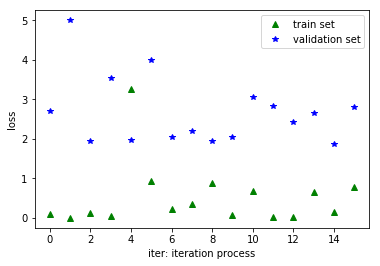

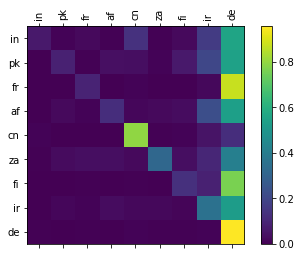

In [15]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line


# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# sphinx_gallery_thumbnail_number = 2
plt.show()

In [16]:
import csv

words_test = []
with open ("cities_test.txt","r",encoding="ISO-8859-1") as f:
    reader = csv.reader(f)
    for row in reader:
        words_test.append(row[0])
        
pred_labels = [predict(word) for word in words_test]
    
output_file = open("../labels.txt","w")
for item in pred_labels:
    output_file.write("%s\n" % item)
    
output_file.close()